# Topic Modeling of LinkedIn Influencers

##  Exploring Trends from LinkedIn Influencers to Guide and Support New or Existing Users

###  Introduction

LinkedIn, the premier professional network, provides individuals with a platform to cultivate influence and make a lasting impact. Using a dataset of LinkedIn influencers, we have developed a topic modeling system that uncovers frequently used words and themes, offering insights on how to become influential on the platform. This system serves as a guide for both new and existing users, empowering them to navigate LinkedIn effectively and build their personal brand by leveraging the strategies of successful influencers.

### Dataset
The dataset at hand comprises comprehensive information on LinkedIn influencers, including post details.

[Link to dataset on Kaggle](https://www.kaggle.com/datasets/shreyasajal/linkedin-influencers-data)


### Group Members
1. Ebenezer Acquah - 10885076
2. Eugene Cobbah - 10885076


### Libraries

In [ ]:
import spacy #nlp
import numpy as np #numerical computation
import pandas as pd #data manipulation
import seaborn as sns #data visualization
import matplotlib.pyplot as plt #data visualization
import itertools as it #transform object into generator
import re #remove patterns from strings
from gensim.models import Phrases #return sentences or phrases of grouped words.
from gensim.corpora import Dictionary #create dictionary for Latent Dirichlet Allocation (LDA)
from gensim.models.ldamulticore import LdaModel #Load and train LDA Models
from gensim.models import CoherenceModel #calculate the coherence of our LDA model
from IPython.display import display  # Import display from IPython for enhanced output display
from tqdm import tqdm  # Import tqdm for progress bars
from collections import Counter  # Import Counter for counting occurrences
import ast  # Import ast for abstract syntax tree manipulation

from sklearn.feature_extraction.text import CountVectorizer  # Import CountVectorizer for text feature extraction
from sklearn.decomposition import LatentDirichletAllocation  # Import LatentDirichletAllocation for topic modeling
from nltk.corpus import stopwords  # Import stopwords from NLTK for common word removal
from nltk.tokenize import word_tokenize  # Import word_tokenize from NLTK for word tokenization
from sklearn.decomposition import TruncatedSVD  # Import TruncatedSVD for dimensionality reduction
from gensim import corpora  # Import corpora from gensim for text corpus creation
import gensim  # Import gensim for topic modeling and NLP tasks

import matplotlib.pyplot as plt  # Import matplotlib for plotting
import matplotlib.mlab as mlab  # Import mlab for additional matplotlib functions

from textblob import TextBlob  # Import TextBlob for text processing and sentiment analysis
import scipy.stats as stats  # Import stats from scipy for statistical functions

from sklearn.manifold import TSNE  # Import TSNE for t-distributed Stochastic Neighbor Embedding

### Load Dataset

In [ ]:
data_dir = "/content/drive/MyDrive/LinkedIn Hackathon/influencers_data.csv"

df = pd.read_csv(data_dir, sep=',', index_col=False, dtype='unicode')

## Data Preprocessing

In [ ]:
# View the first 5 rows in the dataset
df.head()

Unnamed: 0            name        headline location followers connections  \
0          0  Nicholas Wyman  CEO IWSI Group      NaN    6484.0        500+   
1          1  Nicholas Wyman  CEO IWSI Group      NaN    6484.0        500+   
2          2  Nicholas Wyman  CEO IWSI Group      NaN    6484.0        500+   
3          3  Nicholas Wyman  CEO IWSI Group      NaN    6484.0        500+   
4          4  Nicholas Wyman  CEO IWSI Group      NaN    6484.0        500+   

                                               about    time_spent  \
0  Nicholas Wyman for the past 25 years has shone...     1 day ago   
1  Nicholas Wyman for the past 25 years has shone...    1 week ago   
2  Nicholas Wyman for the past 25 years has shone...  2 months ago   
3  Nicholas Wyman for the past 25 years has shone...  2 months ago   
4  Nicholas Wyman for the past 25 years has shone...  2 months ago   

                                             content  \
0  Robert Lerman  writes that achieving a healthy...   
1  National disability advocate  Sara Hart Weir, ...   
2                                                NaN   
3  Exploring in this months Talent Management & H...   
4  I count myself fortunate to have spent time wi...   

                                       content_links media_type  \
0  [['https://www.linkedin.com/in/ACoAAACy1HkBviR...    article   
1  [['https://www.linkedin.com/in/ACoAAAHsfJgBb7_...        NaN   
2                                                 []        NaN   
3  [['https://www.linkedin.com/in/ACoAAAADlGIBLfn...    article   
4  [['https://www.linkedin.com/in/ACoAABhNxDUB9IX...    article   

                                           media_url num_hashtags  \
0  ['https://www.urban.org/urban-wire/its-time-mo...            4   
1                                                 []            0   
2                                                 []            0   
3  ['https://www.tlnt.com/apprenticeships-that-br...            4   
4  ['https://gritdaily.com/the-legacy-of-verified...            3   

  hashtag_followers                                           hashtags  \
0                 0  [['#workbasedlearning', 'https://www.linkedin....   
1                 0                                                 []   
2                 0                                                 []   
3                 0  [['#careerplanning', 'https://www.linkedin.com...   
4                 0  [['#verifiedresumes', 'https://www.linkedin.co...   

  reactions comments views votes  
0        12        1   NaN   NaN  
1        11        0   NaN   NaN  
2        15        0   NaN   NaN  
3        44        0   NaN   NaN  
4        22        2   NaN   NaN

In [ ]:
# Check the rows and columns in the data
df.shape

(34012, 19)

There are 34012 rows and 19 columns in the dataset

In [ ]:
# columns in the data
df.columns

Index(['Unnamed: 0', 'name', 'headline', 'location', 'followers',
       'connections', 'about', 'time_spent', 'content', 'content_links',
       'media_type', 'media_url', 'num_hashtags', 'hashtag_followers',
       'hashtags', 'reactions', 'comments', 'views', 'votes'],
      dtype='object')

### Meaning of columns

Unnamed: to delete<br>
Name: LinkedIn profile<br>
Headline: below the name in LinkedIn<br>
Location: some NaN; List: example ['Gloucester,', 'Massachusetts,', 'United', 'States']<br>
Followers: number of followers (connections + followers in LinkedIn); This dataset is composed of influencers with a lot of followers<br>
Connections: careful of 500+ (is it useful?) => only 2 different values => delete it! <br>
About: about section in the profile<br>
Time_spent: time between the post date & when this dataset was created (categorical values: 1 month ago, 5 years ago, ...)<br>
Content: core of the content<br>
Content_links: every link contained in the post: profile, #, media (article, website, picture,...)<br>
Media_type: media added to the post: article, image, photo,...; Some NaN<br>
Media_url: link of the media<br>
Num_hashtags: number<br>
Hashtag_followers: nulls<br>
Hashtags: [['#',"link"]]<br>
Reactions: number of likes, supports, loves,... counted as identical<br>
Comments: number of comments<br>
Views: NaN<br>
Votes: 82 non-null, composed of decimal numbers too. Weird. Because it is insignificant, we could delete it.<br>

In [ ]:
#total number of columns
df.columns.value_counts().sum()

19

We can observe that there are 19 features in the dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34012 entries, 0 to 34011
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         34012 non-null  object
 1   name               34012 non-null  object
 2   headline           34012 non-null  object
 3   location           31740 non-null  object
 4   followers          33970 non-null  object
 5   connections        25713 non-null  object
 6   about              34012 non-null  object
 7   time_spent         34011 non-null  object
 8   content            31996 non-null  object
 9   content_links      34012 non-null  object
 10  media_type         26779 non-null  object
 11  media_url          34012 non-null  object
 12  num_hashtags       34012 non-null  object
 13  hashtag_followers  34012 non-null  object
 14  hashtags           34012 non-null  object
 15  reactions          34012 non-null  object
 16  comments           34012 non-null  objec

This pandas DataFrame has 34,012 entries and 19 columns. The columns contain a combination of integer, float, and object (string) data types. Some columns have missing values, denoted by "non-null count." The 'views' column has all null values, and the 'votes' column has 86 non-null objects.

In [ ]:
# Missing values
df.isna().sum()

Unnamed: 0               0
name                     0
headline                 0
location              2272
followers               42
connections           8299
about                    0
time_spent               1
content               2016
content_links            0
media_type            7233
media_url                0
num_hashtags             0
hashtag_followers        0
hashtags                 0
reactions                0
comments                 0
views                34012
votes                33926
dtype: int64

Some columns in the dataset have missing values, namely: location, followers, connections, content, media_type, views, and votes.



In [ ]:
#drop unnamed, connections, hastag_followers, views and vote
df = df.drop(['Unnamed: 0','connections','hashtag_followers','views','votes'],axis=1)

In [ ]:
df['location']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
34007    NaN
34008    NaN
34009    NaN
34010    NaN
34011    NaN
Name: location, Length: 34012, dtype: object

The 'location' column shows that the missing values are replaced with NaN.

In [ ]:
# Replace Nan by "Unknown"
df['Location'] = df['location'].fillna('Unknown')
df.drop(['location'],axis=1,inplace=True)

## Data Analysis and Visualization

Since we are building a topic modelling, we shall focus on the features listed below:

1. content
2. hashtags
3. headline
4. about

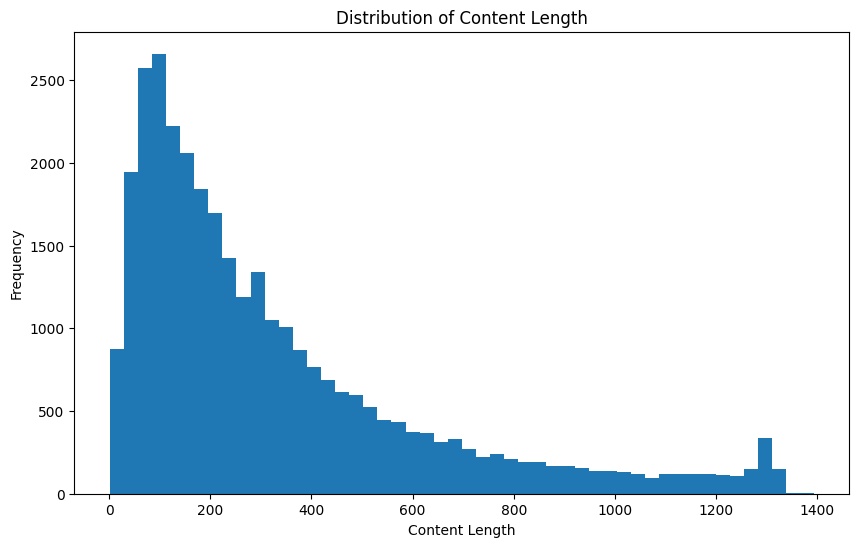

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Calculate the length of each content entry
df['content_length'] = df['content'].str.len()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.hist(df['content_length'].dropna(), bins=50)
plt.title('Distribution of Content Length')
plt.xlabel('Content Length')
plt.ylabel('Frequency')
plt.show()


From the chart above it is evident that most of the post by influencers ranges between 0 to 400.

Use wordcloud to visualize the frequently used words

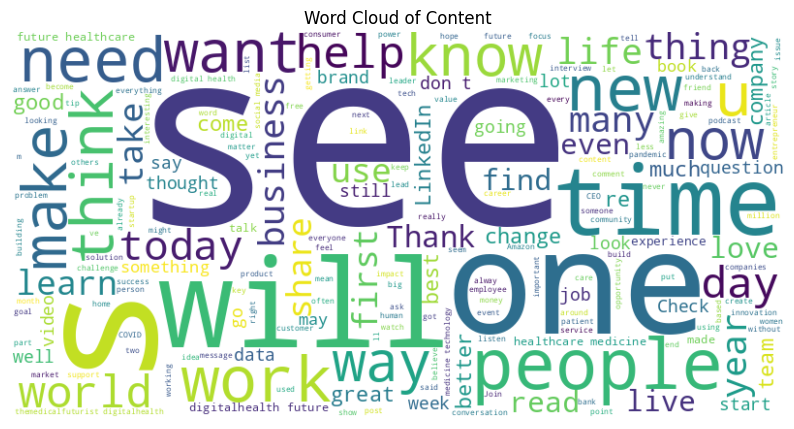

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud


# Remove links from content
df['content'] = df['content'].str.replace(r'http\S+|www.\S+', '', regex=True)

# Concatenate all content into a single string
all_content = ' '.join(df['content'].dropna())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_content)

# Plotting the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Content')
plt.show()


From the wordcloud, we can see the frequently used words in post content.

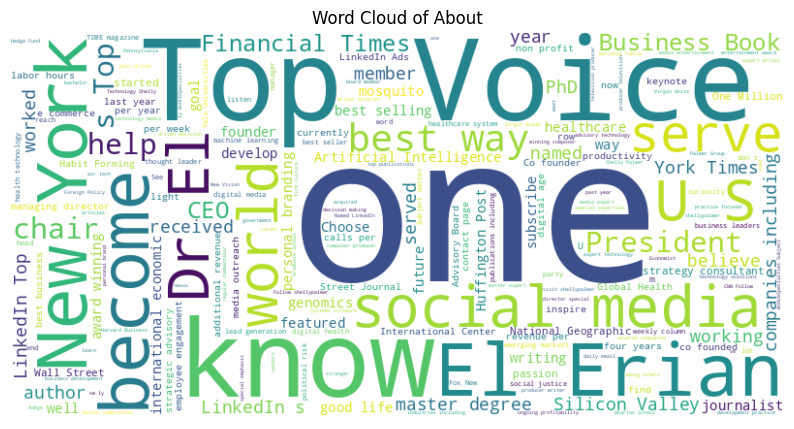

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Concatenate all 'about' values into a single string
all_about = ' '.join(df['about'].dropna())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_about)

# Plotting the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of About')
plt.show()


From the wordcloud we can notice the frequently used words in the about of top influencers

### Plotting a bar graph to visualize word frequency in headline

In [ ]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)

    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [ ]:
count_vectorizer = CountVectorizer()

In [ ]:
text_data = df['headline']

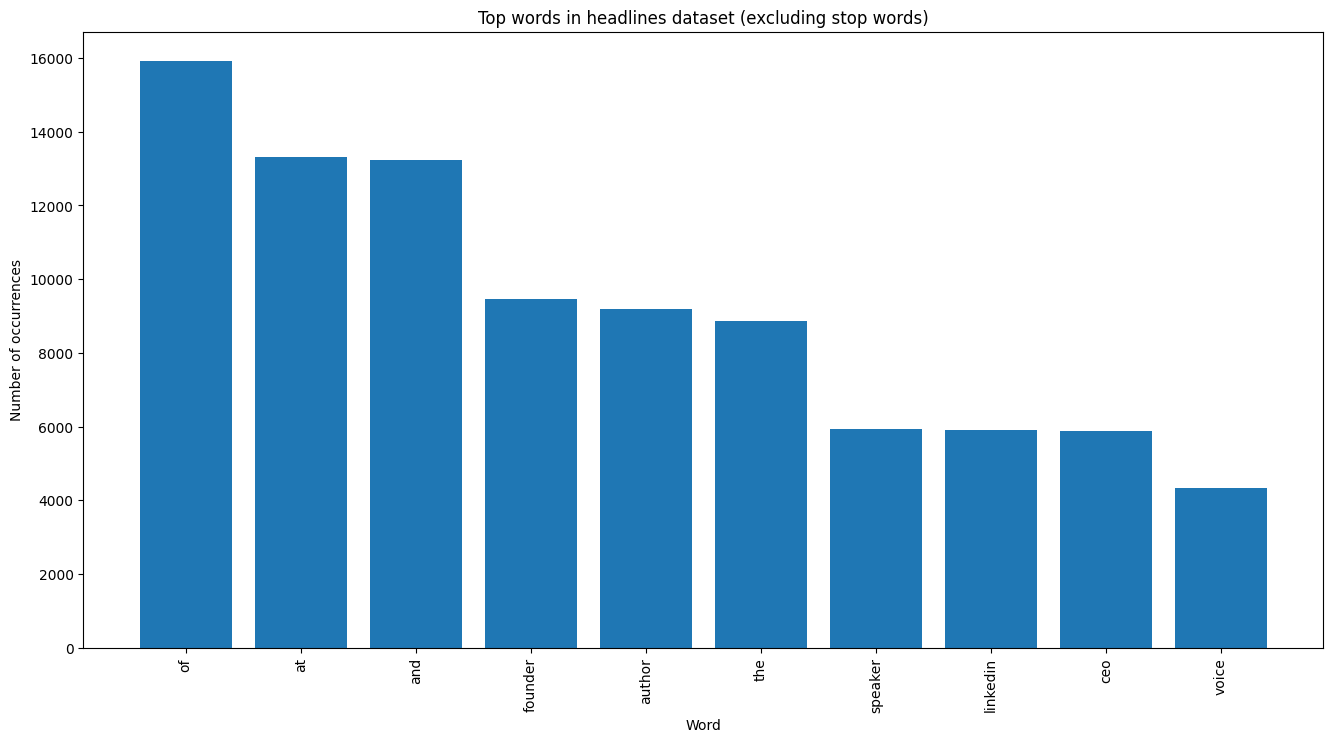

In [ ]:
n_top_words = 10  # Specify the number of top words you want to extract
top_words, word_counts = get_top_n_words(n_top_words, count_vectorizer, text_data)

fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(range(len(top_words)), word_counts)
ax.set_xticks(range(len(top_words)))
ax.set_xticklabels(top_words, rotation='vertical')
ax.set_title('Top words in headlines dataset (excluding stop words)')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurrences')
plt.show()

From the bar graph, we can observe the most frequently used words in influencers headline.

In [ ]:
# !python -m textblob.download_corpora
# !nltk.download('punkt')

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = df.sample(n=10000, random_state=0)

print('Headline before vectorization: {}'.format(small_text_sample['headline'].iloc[23]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample['headline'])

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

Headline before vectorization: Founder and CEO of One Million by One Million (1Mby1M)
Headline after vectorization: 
  (0, 138)	1
  (0, 214)	1
  (0, 114)	1


We transformed the 'headline' feature into a numerical representation using a technique called vectorization. For example, the headline 'Founder and CEO of One Million by One Million (1Mby1M)' was converted into a sparse matrix representation. The vectorization process assigned indices to each word and recorded their corresponding counts. In this specific headline, three words were identified with counts of 1 at indices 138, 214, and 114. This numerical representation allows for further analysis and modeling of the headlines.

In [ ]:
n_topics = 8

## Performing Topic Modelling

* Due to the nature of our dataset, we shall focus on Latent Semantic Analysis and Latent Dirichlet Allocation Models.

### Latent Semantic Analysis

Latent Semantic Analysis (LSA) is a mathematical technique used in natural language processing and information retrieval to analyze the relationships between words and documents.

In [ ]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [ ]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [ ]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [ ]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))
    return top_words

In [ ]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  author speaker futurist director keynote medical institute founder remote assessment
Topic 2:  learner content founder creator entrepreneur enthusiast enterprise engagement endless empower
Topic 3:  linkedin voice ceo marketing media business 4x founder brand writer
Topic 4:  founder million 1mby1m ceo altucher podcast james director managing virgin
Topic 5:  consultant public collective emerson communications author street bestselling speaker wall
Topic 6:  media social reach ghostwriter contributor craft connect help communicate stories
Topic 7:  author group president ceo palmer botkeeper cambridge college queens acts
Topic 8:  managing partner founder ventures middlegame access solutions digital healthcare compliant


We can see from the above the top words spoken by some of the influencers

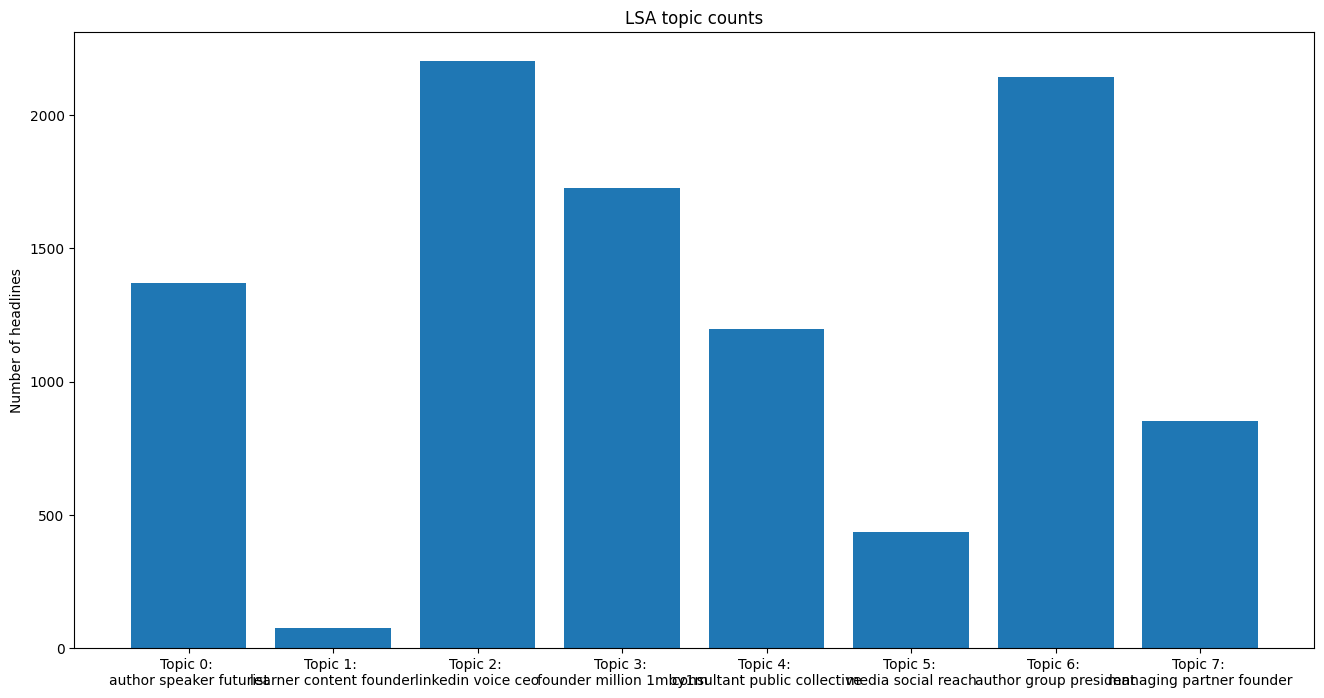

In [ ]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of headlines');
ax.set_title('LSA topic counts');
plt.show()

From the chart, we can observe that Topic 2 and Topic 6 accounted for the highest number of headlines of about 2500, followed by Topic 3.
Topic 1 had the least number of headlines.

## Performing Latent Dirichlet Allocation (LDA)

>-  LDA is a probabilistic topic modeling algorithm used to uncover latent topics within a collection of documents.

In [ ]:
# Combine the relevant features into a single text column
df['text'] = df['content'] + ' ' + df['hashtags'] + ' ' + df['headline'] + ' ' + df['about']

# Tokenize the text and remove stopwords
stop_words = set(stopwords.words('english'))

df['text'] = df['text'].astype(str)  # Convert the 'text' column to string type

df['text'] = df['text'].apply(lambda x: ' '.join([word.lower() for word in word_tokenize(x) if word.lower() not in stop_words]))

# Vectorize the text data
vectorizer = CountVectorizer(max_features=1000)  # Adjust the max_features parameter as needed
X = vectorizer.fit_transform(df['text'])

# Convert the vectorized data to Gensim dictionary and corpus
corpus = gensim.matutils.Sparse2Corpus(X.T)
dictionary = {v: k for k, v in vectorizer.vocabulary_.items()}

# Apply Latent Dirichlet Allocation (LDA)
num_topics = 5  # Adjust the number of topics as needed
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X)

# Print the most significant words for each topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-6:-1]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

Topic 1: marketing, business, com, know, life
Topic 2: sramana, million, one, linkedin, software
Topic 3: linkedin, feed, hashtag, keywords, 3ali
Topic 4: linkedin, business, www, com, international
Topic 5: world, media, linkedin, work, com


We shall use perplexity to measure the accuracy of our finding

>- Perplexity is a measure used to evaluate the quality of a language model or topic model

In [ ]:
# Compute perplexity
perplexity = lda_model.perplexity(X)
print(f"Perplexity: {perplexity}")

Perplexity: 316.9177751938774


## Conclusion

The analysis of the discovered topics or clusters reveals important keywords that can guide new users in their journey to become influencers on LinkedIn. Here are some of the significant keywords and their potential implications:

Marketing, Business, and Know: These keywords suggest that having a strong understanding of marketing strategies and business principles is essential for building influence on LinkedIn. New users can focus on creating content that provides valuable insights and knowledge related to their industry or area of expertise.

LinkedIn, Feed, and Hashtag: These keywords highlight the importance of engaging with the LinkedIn platform itself. New users should actively participate in discussions, comment on relevant posts, and use appropriate hashtags to increase the visibility of their content and attract a wider audience.

Sramana, Million, and Software: These keywords may indicate the significance of showcasing notable achievements and expertise. New users can highlight their accomplishments, such as successful projects or milestones, and demonstrate their proficiency in specific software or tools related to their field.

World, Media, and Work: These keywords imply the importance of establishing a strong online presence beyond LinkedIn. New users can leverage other social media platforms and online channels to share their work, connect with industry influencers, and expand their reach to a global audience.